In [1]:
from functools import partial
from pprint import pprint

import numpy as np
import pandas as pd
import scipy as sp
from sklearn import metrics

from retinopathy.callbacks import cohen_kappa_score, plot_matrix
from retinopathy.models.heads import regression_to_class

In [2]:
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = metrics.cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [3]:
aptos2019_train = pd.read_csv('../data/aptos-2019/train.csv')
# Distribution in best submit
# 0 - 305
# 1 - 258
# 2 - 1116
# 3 - 189
# 4 - 60

submit = [305,258,1116,189, 60]
aptos2019_train = [
    (aptos2019_train['diagnosis'] == 0).sum(),
    (aptos2019_train['diagnosis'] == 1).sum(),
    (aptos2019_train['diagnosis'] == 2).sum(),
    (aptos2019_train['diagnosis'] == 3).sum(),
    (aptos2019_train['diagnosis'] == 4).sum(),
]

aptos2015_train = pd.read_csv('../data/aptos-2015/train_labels.csv')
aptos2015_train = [
    (aptos2015_train['diagnosis'] == 0).sum(),
    (aptos2015_train['diagnosis'] == 1).sum(),
    (aptos2015_train['diagnosis'] == 2).sum(),
    (aptos2015_train['diagnosis'] == 3).sum(),
    (aptos2015_train['diagnosis'] == 4).sum(),    
]

aptos2015_test = pd.read_csv('../data/aptos-2015/test_labels.csv')

aptos2015_test_private = aptos2015_test[aptos2015_test['Usage']=='Private']
aptos2015_test_public = aptos2015_test[aptos2015_test['Usage']=='Public']

aptos2015_test_public = [
    (aptos2015_test_public['diagnosis'] == 0).sum(),
    (aptos2015_test_public['diagnosis'] == 1).sum(),
    (aptos2015_test_public['diagnosis'] == 2).sum(),
    (aptos2015_test_public['diagnosis'] == 3).sum(),
    (aptos2015_test_public['diagnosis'] == 4).sum(),    
]
aptos2015_test_private = np.array([
    (aptos2015_test_private['diagnosis'] == 0).sum(),
    (aptos2015_test_private['diagnosis'] == 1).sum(),
    (aptos2015_test_private['diagnosis'] == 2).sum(),
    (aptos2015_test_private['diagnosis'] == 3).sum(),
    (aptos2015_test_private['diagnosis'] == 4).sum(),    
])

def print_distribution(x):
    x = np.array(x)
    print(x.sum(),x, (100 * x / x.sum()).astype(int))
    

print_distribution(submit)
print_distribution(aptos2019_train)
print_distribution(aptos2015_train)
print_distribution(aptos2015_test_private)
print_distribution(aptos2015_test_public)

1928 [ 305  258 1116  189   60] [15 13 57  9  3]
3662 [1805  370  999  193  295] [49 10 27  5  8]
35126 [25810  2443  5292   873   708] [73  6 15  2  2]
42670 [31403  3042  6282   977   966] [73  7 14  2  2]
10906 [8130  720 1579  237  240] [74  6 14  2  2]


In [4]:
def evaluate_predictions(df):
    
    if 'cls_diagnosis' not in df:
        cls_diagnosis = df['logits'].apply(np.argmax)
    else:
        cls_diagnosis = df['cls_diagnosis']

    if 'reg_diagnosis' not in df:
        reg_diagnosis = df['regression'].apply(regression_to_class).apply(int)
    else:
        reg_diagnosis = df['reg_diagnosis']

    if 'ord_diagnosis' not in df:
        ord_diagnosis = df['ordinal'].apply(regression_to_class).apply(int)
    else:
        ord_diagnosis = df['ord_diagnosis']
        
    y_true = df['diagnosis'].values
    cls_score, _, _ = cohen_kappa_score(y_true, 
                      cls_diagnosis.values, 
                      weights='quadratic')
    
    reg_score, _, _ = cohen_kappa_score(y_true, 
                      reg_diagnosis.values, 
                      weights='quadratic')

    ord_score, _, _ = cohen_kappa_score(y_true, 
                      ord_diagnosis.values, 
                      weights='quadratic')
    
    optR = OptimizedRounder()
    optR.fit(df['regression'], df['diagnosis'])
    coefficients = optR.coefficients()
    reg_optimized = optR.predict(df['regression'], coefficients)
    
    reg_score_opt, _, _ = cohen_kappa_score(df['diagnosis'].values, 
                              reg_optimized, 
                              weights='quadratic')

    optR.fit(df['regression'], df['diagnosis'])
    coefficients = optR.coefficients()
    org_optimized = optR.predict(df['ordinal'], coefficients)

    ord_score_opt, _, _ = cohen_kappa_score(df['diagnosis'].values, 
                              org_optimized, 
                              weights='quadratic')
    
    return {
        'cls_score': cls_score,
        'reg_score': reg_score,
        'ord_score': ord_score,
        'reg_score_opt': reg_score_opt,
        'ord_score_opt': ord_score_opt
    }

def average_predictions_voting(predictions):
    result = predictions[0].copy()
    
    cls_predictions = []
    for p in predictions:
        cls_predictions.append(p['logits'].apply(np.argmax).tolist())
                
    reg_predictions = []
    for p in predictions:
        reg_predictions.append(p['regression'].apply(regression_to_class).apply(int).tolist())

    ord_predictions = []
    for p in predictions:
        ord_predictions.append(p['ordinal'].apply(regression_to_class).apply(int).tolist())
    
    cls_predictions = np.moveaxis(np.array(cls_predictions), 0,-1)
    ord_predictions = np.moveaxis(np.array(ord_predictions), 0,-1)
    reg_predictions = np.moveaxis(np.array(reg_predictions), 0,-1)
    
    result['cls_diagnosis'] = [np.bincount(x).argmax() for x in cls_predictions]
    result['ord_diagnosis'] = [np.bincount(x).argmax() for x in ord_predictions]
    result['reg_diagnosis'] = [np.bincount(x).argmax() for x in reg_predictions]
    
    return result

In [5]:
def drop_features(df:pd.DataFrame):
    if 'features' in df:
        df = df.drop(columns=['features'])
    return df

In [6]:
oof_predictions = [
    # eloquent_yonath
    [
        '../pretrained/806_813_eloquent_yonath/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold0_eloquent_yonath_oof_predictions.pkl',
        '../pretrained/806_813_eloquent_yonath/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold1_eloquent_yonath_oof_predictions.pkl',
        '../pretrained/806_813_eloquent_yonath/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold2_eloquent_yonath_oof_predictions.pkl',
        '../pretrained/806_813_eloquent_yonath/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold3_eloquent_yonath_oof_predictions.pkl',                
    ],
    # eloquent_yonath_tuned
    [
        '../pretrained/806_813_eloquent_yonath_finetuned/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold0_eloquent_yonath_tuned_oof_predictions.pkl',
        '../pretrained/806_813_eloquent_yonath_finetuned/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold1_eloquent_yonath_tuned_oof_predictions.pkl',
        '../pretrained/806_813_eloquent_yonath_finetuned/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold2_eloquent_yonath_tuned_oof_predictions.pkl',
        '../pretrained/806_813_eloquent_yonath_finetuned/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold3_eloquent_yonath_tuned_oof_predictions.pkl',        
    ],
    # zen_golik_tuned
    [
        '../pretrained/Aug14_11_10_zen_golick_finetuned/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold2_zen_golick_tuned_oof_predictions.pkl',
        '../pretrained/Aug14_11_10_zen_golick_finetuned/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold0_zen_golick_tuned_oof_predictions.pkl',
        '../pretrained/Aug14_11_10_zen_golick_finetuned/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold1_zen_golick_tuned_oof_predictions.pkl',
        '../pretrained/Aug14_11_10_zen_golick_finetuned/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold3_zen_golick_tuned_oof_predictions.pkl'
    ]
]

idrid_predictions = [
    # eloquent_yonath
    [
        '../pretrained/806_813_eloquent_yonath/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold0_eloquent_yonath_idrid_test_predictions.pkl',
        '../pretrained/806_813_eloquent_yonath/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold1_eloquent_yonath_idrid_test_predictions.pkl',
        '../pretrained/806_813_eloquent_yonath/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold2_eloquent_yonath_idrid_test_predictions.pkl',
        '../pretrained/806_813_eloquent_yonath/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold3_eloquent_yonath_idrid_test_predictions.pkl',        

    ],
    # eloquent_yonath_tuned
    [
        '../pretrained/806_813_eloquent_yonath_finetuned/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold0_eloquent_yonath_tuned_idrid_test_predictions.pkl',
        '../pretrained/806_813_eloquent_yonath_finetuned/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold1_eloquent_yonath_tuned_idrid_test_predictions.pkl',
        '../pretrained/806_813_eloquent_yonath_finetuned/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold2_eloquent_yonath_tuned_idrid_test_predictions.pkl',
        '../pretrained/806_813_eloquent_yonath_finetuned/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold3_eloquent_yonath_tuned_idrid_test_predictions.pkl',
    ],
    # zen_golik_tuned
    [
        '../pretrained/Aug14_11_10_zen_golick_finetuned/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold0_zen_golick_tuned_idrid_test_predictions.pkl',
        '../pretrained/Aug14_11_10_zen_golick_finetuned/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold1_zen_golick_tuned_idrid_test_predictions.pkl',
        '../pretrained/Aug14_11_10_zen_golick_finetuned/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold2_zen_golick_tuned_idrid_test_predictions.pkl',
        '../pretrained/Aug14_11_10_zen_golick_finetuned/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold3_zen_golick_tuned_idrid_test_predictions.pkl'
    ]
]

aptos2015_test = [
    # eloquent_yonath
    [
        '../pretrained/806_813_eloquent_yonath/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold0_eloquent_yonath_aptos2015_test_predictions.pkl',
        '../pretrained/806_813_eloquent_yonath/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold1_eloquent_yonath_aptos2015_test_predictions.pkl',
        '../pretrained/806_813_eloquent_yonath/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold2_eloquent_yonath_aptos2015_test_predictions.pkl',
        '../pretrained/806_813_eloquent_yonath/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold3_eloquent_yonath_aptos2015_test_predictions.pkl'
    ],
    [
        '../pretrained/806_813_eloquent_yonath_finetuned/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold0_eloquent_yonath_tuned_aptos2015_test_predictions.pkl',
        '../pretrained/806_813_eloquent_yonath_finetuned/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold1_eloquent_yonath_tuned_aptos2015_test_predictions.pkl',
        '../pretrained/806_813_eloquent_yonath_finetuned/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold2_eloquent_yonath_tuned_aptos2015_test_predictions.pkl',
        '../pretrained/806_813_eloquent_yonath_finetuned/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold3_eloquent_yonath_tuned_aptos2015_test_predictions.pkl'
    ],
    # zen_golik_tuned
    [
        '../pretrained/Aug14_11_10_zen_golick_finetuned/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold0_zen_golick_tuned_aptos2015_test_predictions.pkl',
        '../pretrained/Aug14_11_10_zen_golick_finetuned/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold1_zen_golick_tuned_aptos2015_test_predictions.pkl',
        '../pretrained/Aug14_11_10_zen_golick_finetuned/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold2_zen_golick_tuned_aptos2015_test_predictions.pkl',
        '../pretrained/Aug14_11_10_zen_golick_finetuned/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold3_zen_golick_tuned_aptos2015_test_predictions.pkl'
    ]
]

aptos2019_test = [
    # eloquent_yonath
    [
        '../pretrained/806_813_eloquent_yonath/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold0_eloquent_yonath_aptos2019_test_predictions.pkl',
        '../pretrained/806_813_eloquent_yonath/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold1_eloquent_yonath_aptos2019_test_predictions.pkl',
        '../pretrained/806_813_eloquent_yonath/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold2_eloquent_yonath_aptos2019_test_predictions.pkl',
        '../pretrained/806_813_eloquent_yonath/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold3_eloquent_yonath_aptos2019_test_predictions.pkl'
    ],
    # eloquent_yonath_tuned
    [
        '../pretrained/806_813_eloquent_yonath_finetuned/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold0_eloquent_yonath_tuned_aptos2019_test_predictions.pkl',
        '../pretrained/806_813_eloquent_yonath_finetuned/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold1_eloquent_yonath_tuned_aptos2019_test_predictions.pkl',
        '../pretrained/806_813_eloquent_yonath_finetuned/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold2_eloquent_yonath_tuned_aptos2019_test_predictions.pkl',
        '../pretrained/806_813_eloquent_yonath_finetuned/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold3_eloquent_yonath_tuned_aptos2019_test_predictions.pkl'
    ],    
    [
        '../pretrained/Aug14_11_10_zen_golick_finetuned/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold0_zen_golick_tuned_aptos2019_test_predictions.pkl',
        '../pretrained/Aug14_11_10_zen_golick_finetuned/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold1_zen_golick_tuned_aptos2019_test_predictions.pkl',
        '../pretrained/Aug14_11_10_zen_golick_finetuned/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold2_zen_golick_tuned_aptos2019_test_predictions.pkl',
        '../pretrained/Aug14_11_10_zen_golick_finetuned/seresnext50d_gwap_512_medium_aptos2019_messidor_idrid_fold3_zen_golick_tuned_aptos2019_test_predictions.pkl',
    ]
]

In [7]:
oof_predictions_flatten = []
for i, oof in enumerate(oof_predictions):
    all_predictions = pd.concat([drop_features(pd.read_pickle(x)) for x in oof])
    scores = evaluate_predictions(all_predictions)
    print('Model', i)
    pprint(scores)
    oof_predictions_flatten.append(all_predictions)


Model 0
{'cls_score': 0.9661645233451795,
 'ord_score': 0.0,
 'ord_score_opt': 0.0,
 'reg_score': 0.9677775996149371,
 'reg_score_opt': 0.9683677756189432}
Model 1
{'cls_score': 0.9668472437403195,
 'ord_score': 0.9680320404990821,
 'ord_score_opt': 0.9676697813520029,
 'reg_score': 0.9685358412678617,
 'reg_score_opt': 0.969012703009653}
Model 2
{'cls_score': 0.9361854909758479,
 'ord_score': 0.9419968388643427,
 'ord_score_opt': 0.9317038333042926,
 'reg_score': 0.7249185737439874,
 'reg_score_opt': 0.8395063324472763}


In [8]:
def average_predictions_pd(predictions):
    result = predictions[0].copy()
    
    for column in ['logits','regression','ordinal']:
        accumulator = np.zeros_like(np.array(predictions[0][column].values.tolist())).astype(np.float32)
        # print(accumulator.shape)
        for p in predictions:
            pred = np.array(p[column].values.tolist())
            # if min is not None or max is not None:
            #     pred = np.clip(pred, min, max)
            accumulator += pred
            # print(pred.shape)
        accumulator /= len(predictions)
        
        result[column] = accumulator.tolist()
        
    return result

In [9]:
print('Scores on IDRID')
for i, per_fold_predictions in enumerate(idrid_predictions):
    per_fold_predictions = [drop_features(pd.read_pickle(x)) for x in per_fold_predictions]
    per_fold_scores = []
    for p in per_fold_predictions:
        per_fold_scores.append(evaluate_predictions(p))
    df = pd.DataFrame.from_records(per_fold_scores)
    
    averaged_idrid = average_predictions_pd(per_fold_predictions)
    scores = evaluate_predictions(averaged_idrid)
    
    print('Model', i,'per fold')
    print(df)
    print('Averaged score')
    pprint(scores)

Scores on IDRID
Model 0 per fold
   cls_score  ord_score  ord_score_opt  reg_score  reg_score_opt
0   0.923324        0.0            0.0   0.902972       0.907374
1   0.916120        0.0            0.0   0.939737       0.946278
2   0.937564        0.0            0.0   0.926579       0.933284
3   0.948820        0.0            0.0   0.937154       0.949939
Averaged score
{'cls_score': 0.9589343089659701,
 'ord_score': 0.0,
 'ord_score_opt': 0.0,
 'reg_score': 0.9593227032630696,
 'reg_score_opt': 0.9701809408926417}
Model 1 per fold
   cls_score  ord_score  ord_score_opt  reg_score  reg_score_opt
0   0.903904   0.905958       0.905958   0.918495       0.919472
1   0.923607   0.931910       0.937752   0.939266       0.948133
2   0.935092   0.926020       0.926020   0.931137       0.931137
3   0.933012   0.936836       0.944047   0.931087       0.945602
Averaged score
{'cls_score': 0.9589343089659701,
 'ord_score': 0.9562654544546295,
 'ord_score_opt': 0.9562654544546295,
 'reg_score': 0.

In [10]:
print('Scores on APTOS2015')
for i, per_fold_predictions in enumerate(aptos2015_test):
    per_fold_predictions = [drop_features(pd.read_pickle(x)) for x in per_fold_predictions]
    per_fold_scores = []
    for p in per_fold_predictions:
        per_fold_scores.append(evaluate_predictions(p))
    df = pd.DataFrame.from_records(per_fold_scores)
    
    averaged_idrid = average_predictions_pd(per_fold_predictions)
    scores = evaluate_predictions(averaged_idrid)
    
    print('Model', i,'per fold')
    print(df)
    print('Averaged score')
    pprint(scores)
    print()

    

Scores on APTOS2015
Model 0 per fold
   cls_score  ord_score  ord_score_opt  reg_score  reg_score_opt
0   0.553644        0.0      -0.000044   0.565727       0.580166
1   0.569620        0.0       0.000000   0.586505       0.609301
2   0.566706        0.0       0.000000   0.576125       0.599635
3   0.583379        0.0       0.000000   0.597037       0.611333
Averaged score
{'cls_score': 0.590829515168313,
 'ord_score': 0.0,
 'ord_score_opt': 3.632851390544811e-05,
 'reg_score': 0.6028985240041496,
 'reg_score_opt': 0.6269192585215598}

Model 1 per fold
   cls_score  ord_score  ord_score_opt  reg_score  reg_score_opt
0   0.546211   0.557801       0.573593   0.563906       0.578635
1   0.565384   0.562136       0.594750   0.586305       0.614672
2   0.543929   0.565619       0.581476   0.563574       0.591760
3   0.581099   0.594077       0.606240   0.600671       0.615980
Averaged score
{'cls_score': 0.57875473326728,
 'ord_score': 0.5947256497328951,
 'ord_score_opt': 0.62100886417948

In [11]:
predictions = []

for i, per_fold_predictions in enumerate(aptos2019_test[1:]):
    for df in [drop_features(pd.read_pickle(x)) for x in per_fold_predictions]:
        df['cls_diagnosis'] = df['logits'].apply(np.argmax)
        df['reg_diagnosis'] = df['regression'].apply(regression_to_class).apply(int)
        df['ord_diagnosis'] = df['ordinal'].apply(regression_to_class).apply(int)
        
        predictions.append(df)
    

D:\Develop\Kaggle\Kaggle-2019-Blindness-Detection\retinopathy\callbacks.py:149: UserWarning:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.



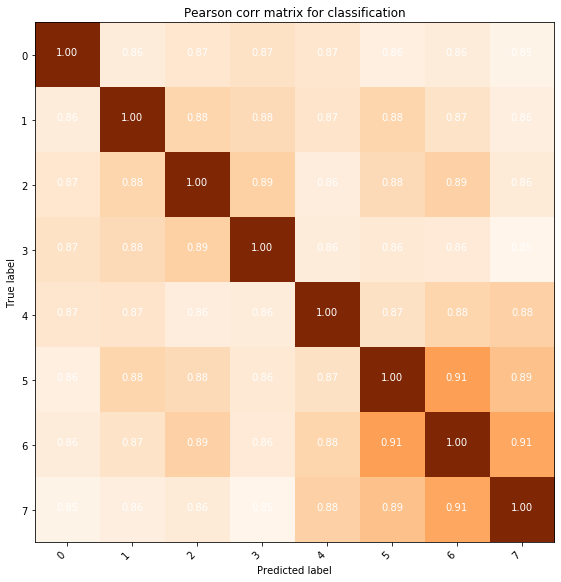

In [12]:
N = len(predictions)
pearson_cls_matrix = np.zeros((N,N))
pearson_ord_matrix = np.zeros((N,N))
pearson_reg_matrix = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        pearson_cls_matrix[i,j] = predictions[i]['cls_diagnosis'].corr(predictions[j]['cls_diagnosis'], method='pearson')
        pearson_reg_matrix[i,j] = predictions[i]['reg_diagnosis'].corr(predictions[j]['reg_diagnosis'], method='pearson')
        pearson_ord_matrix[i,j] = predictions[i]['ord_diagnosis'].corr(predictions[j]['ord_diagnosis'], method='pearson')
        
plot_matrix(pearson_cls_matrix, figsize=(8,8), class_names=range(N), title='Pearson corr matrix for classification')

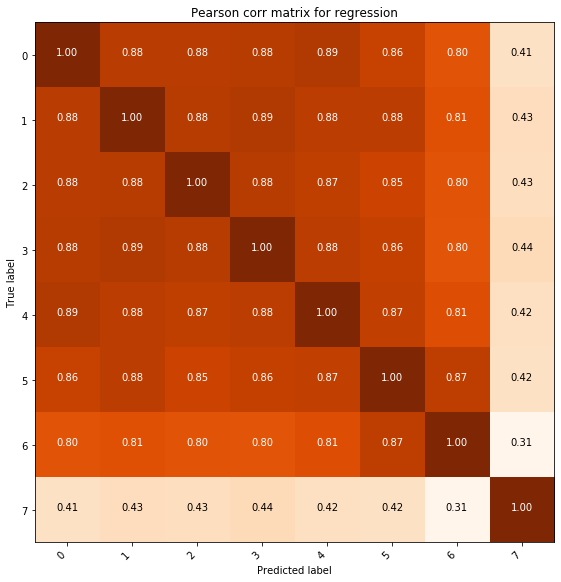

In [13]:
plot_matrix(pearson_reg_matrix, figsize=(8,8),class_names=range(N), title='Pearson corr matrix for regression')

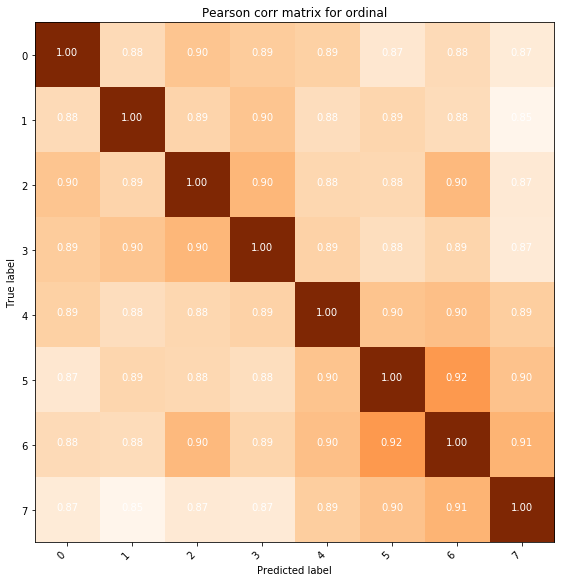

In [14]:
plot_matrix(pearson_ord_matrix, figsize=(8,8),class_names=range(N), title='Pearson corr matrix for ordinal')

In [15]:
# Make train


x_features = []
y = None

for i, per_fold_predictions in enumerate(aptos2015_test[1:]):    
    for df in [drop_features(pd.read_pickle(x)) for x in per_fold_predictions]:     
        logits = np.array(df['logits'].values.tolist())
        ordinal = np.array(df['ordinal'].tolist()).reshape(-1,1)
        
        x = np.concatenate([logits, ordinal], axis=1)
        x_features.append(x)
        y = df['diagnosis'].values

x_features = np.concatenate(x_features, axis=1)
print(x_features.shape, y.shape)

(42670, 48) (42670,)


In [16]:
holdout_x = []
holdout_y = []
for i, per_fold_predictions in enumerate(idrid_predictions[1:]):    
    for df in [drop_features(pd.read_pickle(x)) for x in per_fold_predictions]:     
        logits = np.array(df['logits'].values.tolist())
        ordinal = np.array(df['ordinal'].tolist()).reshape(-1,1)
        
        x = np.concatenate([logits, ordinal], axis=1)
        holdout_x.append(x)
        holdout_y = df['diagnosis'].values

holdout_x = np.concatenate(holdout_x, axis=1)
print(holdout_x.shape, holdout_y.shape)


(103, 48) (103,)


In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
x_features = scaler.fit_transform(x_features)
holdout_x = scaler.transform(holdout_x)

X_train, X_test, y_train, y_test = train_test_split(x_features, y, test_size=.25, random_state=42, stratify=y)


In [18]:
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

names = [
    # "Nearest Neighbors", 
    #      "Linear SVM", 
    #      "RBF SVM", 
    #      "Gaussian Process",
         "Decision Tree",
         "Decision Tree",
         "Random Forest", 
         "Random Forest", 
         "Neural Net", 
         "Neural Net", 
         "AdaBoost",
         "AdaBoost",
         # "Naive Bayes", 
         # "QDA"
         ]

classifiers = [
    # KNeighborsClassifier(3),
    # SVC(kernel="linear", C=0.025),
    # SVC(gamma=2, C=1),
    # GaussianProcessClassifier(1.0 * RBF(1.0)),
    # DecisionTreeClassifier(max_depth=5),
    # DecisionTreeClassifier(max_depth=10),
    RandomForestClassifier(max_depth=5, n_estimators=32, max_features=10),
    RandomForestClassifier(max_depth=4, n_estimators=32, max_features=6),
    # MLPClassifier(alpha=1, max_iter=1000),
    # MLPClassifier(alpha=0.01, max_iter=1000),
    AdaBoostClassifier(),
    AdaBoostClassifier(learning_rate=0.1),
    # GaussianNB(),
    # QuadraticDiscriminantAnalysis()
]


In [19]:
 # iterate over classifiers
for clf in classifiers:
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    
    y_pred = clf.predict(X_test)
    kappa_test,_,_= cohen_kappa_score(y_pred, 
                              y_test, 
                              weights='quadratic')

    y_pred_hold = clf.predict(holdout_x)
    kappa_hold,_,_= cohen_kappa_score(holdout_y, 
                              y_pred_hold, 
                              weights='quadratic')

    print(score, kappa_test, kappa_hold)

0.7919010123734533 0.5779758643724118 0.8770215999131662
0.7882452193475815 0.5674660849468813 0.8489799338109003
0.7771841019872516 0.5750617322737381 0.7251990794484837
0.7789651293588301 0.5446426440073768 0.8011931917880329


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

#create a new random forest classifier
rf = RandomForestClassifier()
#create a dictionary of all values we want to test for n_estimators
params_rf = {'n_estimators': [32, 64, 128], 
             'max_depth':[2,4,8],
             'max_features':[4,8,16]}
#use gridsearch to test all values for n_estimators
rf_gs = GridSearchCV(rf, params_rf, cv=5)
#fit model to training data
rf_gs.fit(x_features, y)

#save best model
rf_best = rf_gs.best_estimator_
#check best n_estimators value
print(rf_gs.best_params_)

y_pred_hold = rf_best.predict(holdout_x)
kappa_hold,_,_= cohen_kappa_score(holdout_y, 
                          y_pred_hold, 
                          weights='quadratic')

print(kappa_hold)

{'max_depth': 8, 'max_features': 16, 'n_estimators': 64}
0.8539517026242883


In [22]:
cls = RandomForestClassifier(max_depth=5, n_estimators=32, max_features=10)
cls.fit(X_train, y_train)
score = clf.score(X_test, y_test)
y_pred = clf.predict(X_test)
kappa_test,_,_= cohen_kappa_score(y_pred, 
                          y_test, 
                          weights='quadratic')

y_pred_hold = clf.predict(holdout_x)
kappa_hold,_,_= cohen_kappa_score(holdout_y, 
                          y_pred_hold, 
                          weights='quadratic')

print(score, kappa_test, kappa_hold)

0.7789651293588301 0.5446426440073768 0.8011931917880329


In [23]:
cls = RandomForestClassifier(max_depth=8, n_estimators=64, max_features=16)
cls.fit(X_train, y_train)
score = clf.score(X_test, y_test)
y_pred = clf.predict(X_test)
kappa_test,_,_= cohen_kappa_score(y_pred, 
                          y_test, 
                          weights='quadratic')

y_pred_hold = clf.predict(holdout_x)
kappa_hold,_,_= cohen_kappa_score(holdout_y, 
                          y_pred_hold, 
                          weights='quadratic')

print(score, kappa_test, kappa_hold)



0.7789651293588301 0.5446426440073768 0.8011931917880329


In [26]:
df = pd.read_pickle('../pretrained/Aug18_19_45_youthful_mccarthy/seresnext50d_gapv2_512_medium_aptos2019_messidor_idrid_fold0_youthful_mccarthy_idrid_test_predictions.pkl')
print(len(df))
features = df['features'].values
print(features.shape)

103
(103,)


,image_id,diagnosis,logits,regression,ordinal,features
0,IDRiD_001,4,"[0.0002004421257879585, 0.003722419962286949, ...",0.223030,3.837633,"[0.0, 0.8950192928314209, 3.9884204864501953, ..."
1,IDRiD_002,4,"[0.07064065337181091, 0.18897408246994019, 0.4...",0.100043,2.138892,"[0.11608928442001343, 0.0029698400758206844, 0..."
2,IDRiD_003,4,"[0.03960813209414482, 0.13607507944107056, 0.5...",0.053579,2.181868,"[0.0059122927486896515, 0.039692386984825134, ..."
3,IDRiD_004,4,"[0.00197446346282959, 0.018390433862805367, 0....",0.011290,3.743105,"[0.0, 0.4652225375175476, 3.844611406326294, 0..."
4,IDRiD_005,4,"[0.0024857562966644764, 0.017686881124973297, ...",-0.067265,3.641033,"[0.0016629655146971345, 0.22062775492668152, 3..."
